In [1]:
print("hello")
from datetime import datetime
import os
import pandas as pd
from datetime import datetime, timezone, timedelta
import pytz
import re
import numpy as np
import logging
import catboost

from catboost import CatBoostClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


hello


In [20]:
import matplotlib.pyplot as plt

In [6]:
df = pd.read_parquet('CLEANED_V8C_(DEP_STACKING_INSERTED, ATA_REMOVED).parquet', engine='pyarrow')


In [7]:
print(df.shape)

(11669787, 49)


In [8]:
df.head()

,Airline Code,Aircraft Registration,Operator,Type Code,Mode S,Serial Number,Age(years),FROM,TO,Arrival_Delayed,...,STA_UTC_time_of_year_cosine,STA_UTC_day_of_year,STA_UTC_week_of_year,STA_UTC_weekday,STA_UTC_hour_of_day,lgb_pred_dep,xgb_pred_dep,catboost_pred_dep,y_dep,final_pred_dep
0,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,YIN,TFU,True,...,-0.492533,244.0,35.0,5.0,5.0,1.0,1.0,1.0,1,1
1,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,TFU,YIN,False,...,-0.492533,244.0,35.0,5.0,3.0,1.0,1.0,1.0,1,1
2,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,URC,TFU,True,...,-0.507430,243.0,35.0,4.0,19.0,1.0,1.0,1.0,1,1
3,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,TFU,URC,False,...,-0.507430,243.0,35.0,4.0,8.0,1.0,1.0,1.0,1,1
4,3u-csc,b-30cr,Sichuan Airlines,A20N,781848,8873.0,5.0,ZHA,TFU,False,...,-0.507430,243.0,35.0,4.0,2.0,1.0,1.0,1.0,1,1


In [9]:
print(df.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'Arrival_Delayed', 'STD_temp_scaled', 'STD_dwpt_scaled',
       'STD_rhum_scaled', 'STD_prcp_scaled', 'STD_snow_scaled',
       'STD_wdir_scaled', 'STD_wspd_scaled', 'STD_wpgt_scaled',
       'STD_pres_scaled', 'STD_tsun_scaled', 'STD_coco_scaled',
       'STA_temp_scaled', 'STA_dwpt_scaled', 'STA_rhum_scaled',
       'STA_prcp_scaled', 'STA_snow_scaled', 'STA_wdir_scaled',
       'STA_wspd_scaled', 'STA_wpgt_scaled', 'STA_pres_scaled',
       'STA_tsun_scaled', 'STA_coco_scaled', 'STD_UTC_time_of_day_cosine',
       'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year',
       'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day',
       'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine',
       'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday',
       'STA_UTC_hour_of_day', 'lgb_pred_dep', 'xgb_pred_dep',
     

In [10]:
df_Arrival = pd.read_parquet('CLEANED_V6.1.parquet', engine='pyarrow')

In [11]:
df_Arrival.shape

(11669787, 67)

In [12]:
print(df_Arrival.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'Arrival_Delayed', 'Departure_Status', 'STD_temp_scaled',
       'STD_dwpt_scaled', 'STD_rhum_scaled', 'STD_prcp_scaled',
       'STD_snow_scaled', 'STD_wdir_scaled', 'STD_wspd_scaled',
       'STD_wpgt_scaled', 'STD_pres_scaled', 'STD_tsun_scaled',
       'STD_coco_scaled', 'ATD_temp_scaled', 'ATD_dwpt_scaled',
       'ATD_rhum_scaled', 'ATD_prcp_scaled', 'ATD_snow_scaled',
       'ATD_wdir_scaled', 'ATD_wspd_scaled', 'ATD_wpgt_scaled',
       'ATD_pres_scaled', 'ATD_tsun_scaled', 'ATD_coco_scaled',
       'STA_temp_scaled', 'STA_dwpt_scaled', 'STA_rhum_scaled',
       'STA_prcp_scaled', 'STA_snow_scaled', 'STA_wdir_scaled',
       'STA_wspd_scaled', 'STA_wpgt_scaled', 'STA_pres_scaled',
       'STA_tsun_scaled', 'STA_coco_scaled', 'ATA_temp_scaled',
       'ATA_dwpt_scaled', 'ATA_rhum_scaled', 'ATA_prcp_scaled',
       'ATA_snow_scaled', 'ATA_w

# Combine DF for predicting Arrivals

## Remove all Unnecessary columns

### Arrival

In [13]:
df_Arrival = df_Arrival["Arrival_Delayed"]

In [14]:
df_Arrival.head()

0     True
1    False
2     True
3    False
4    False
Name: Arrival_Delayed, dtype: bool

### With Departure Stacked

In [15]:
print(df.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'Arrival_Delayed', 'STD_temp_scaled', 'STD_dwpt_scaled',
       'STD_rhum_scaled', 'STD_prcp_scaled', 'STD_snow_scaled',
       'STD_wdir_scaled', 'STD_wspd_scaled', 'STD_wpgt_scaled',
       'STD_pres_scaled', 'STD_tsun_scaled', 'STD_coco_scaled',
       'STA_temp_scaled', 'STA_dwpt_scaled', 'STA_rhum_scaled',
       'STA_prcp_scaled', 'STA_snow_scaled', 'STA_wdir_scaled',
       'STA_wspd_scaled', 'STA_wpgt_scaled', 'STA_pres_scaled',
       'STA_tsun_scaled', 'STA_coco_scaled', 'STD_UTC_time_of_day_cosine',
       'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year',
       'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day',
       'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine',
       'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday',
       'STA_UTC_hour_of_day', 'lgb_pred_dep', 'xgb_pred_dep',
     

In [16]:
df = df.drop(columns = ['lgb_pred_dep', 'xgb_pred_dep',
       'catboost_pred_dep', 'y_dep'])

In [17]:
print(df.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'Arrival_Delayed', 'STD_temp_scaled', 'STD_dwpt_scaled',
       'STD_rhum_scaled', 'STD_prcp_scaled', 'STD_snow_scaled',
       'STD_wdir_scaled', 'STD_wspd_scaled', 'STD_wpgt_scaled',
       'STD_pres_scaled', 'STD_tsun_scaled', 'STD_coco_scaled',
       'STA_temp_scaled', 'STA_dwpt_scaled', 'STA_rhum_scaled',
       'STA_prcp_scaled', 'STA_snow_scaled', 'STA_wdir_scaled',
       'STA_wspd_scaled', 'STA_wpgt_scaled', 'STA_pres_scaled',
       'STA_tsun_scaled', 'STA_coco_scaled', 'STD_UTC_time_of_day_cosine',
       'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year',
       'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day',
       'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine',
       'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday',
       'STA_UTC_hour_of_day', 'final_pred_dep'],
      dtype='objec

In [19]:
df["Y_arrival"] = df_Arrival

In [20]:
print(df.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'Arrival_Delayed', 'STD_temp_scaled', 'STD_dwpt_scaled',
       'STD_rhum_scaled', 'STD_prcp_scaled', 'STD_snow_scaled',
       'STD_wdir_scaled', 'STD_wspd_scaled', 'STD_wpgt_scaled',
       'STD_pres_scaled', 'STD_tsun_scaled', 'STD_coco_scaled',
       'STA_temp_scaled', 'STA_dwpt_scaled', 'STA_rhum_scaled',
       'STA_prcp_scaled', 'STA_snow_scaled', 'STA_wdir_scaled',
       'STA_wspd_scaled', 'STA_wpgt_scaled', 'STA_pres_scaled',
       'STA_tsun_scaled', 'STA_coco_scaled', 'STD_UTC_time_of_day_cosine',
       'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year',
       'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day',
       'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine',
       'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday',
       'STA_UTC_hour_of_day', 'final_pred_dep', 'Y_arrival'],
     

In [21]:
df.tail(10)

,Airline Code,Aircraft Registration,Operator,Type Code,Mode S,Serial Number,Age(years),FROM,TO,Arrival_Delayed,...,STD_UTC_weekday,STD_UTC_hour_of_day,STA_UTC_time_of_day_cosine,STA_UTC_time_of_year_cosine,STA_UTC_day_of_year,STA_UTC_week_of_year,STA_UTC_weekday,STA_UTC_hour_of_day,final_pred_dep,Y_arrival
11669777,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,SIN,DPS,False,...,5,0,0.737277,-0.033324,272.0,39.0,5.0,2.0,1,False
11669778,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,DPS,SIN,False,...,4,18,0.722364,-0.050511,271.0,39.0,4.0,21.0,1,False
11669779,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,SIN,DPS,False,...,4,14,-0.173648,-0.050511,271.0,39.0,4.0,17.0,1,False
11669780,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,DPS,SIN,False,...,4,5,-0.537300,-0.050511,271.0,39.0,4.0,8.0,1,False
11669781,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,SIN,DPS,False,...,4,1,0.342020,-0.050511,271.0,39.0,4.0,4.0,1,False
11669782,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,NGO,SIN,False,...,2,2,0.793353,-0.084835,269.0,39.0,2.0,2.0,1,False
11669783,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,CHS,NGO,True,...,1,5,0.237686,-0.101962,268.0,39.0,1.0,18.0,1,True
11669784,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,CHS,CHS,True,...,1,10,-0.928810,-0.336289,254.0,37.0,1.0,13.0,1,True
11669785,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,CHS,CHS,True,...,6,15,-0.492424,-0.477489,245.0,35.0,6.0,16.0,1,True
11669786,SQ-SIA,9V-SDA,Singapore Airlines,B78X,76CC81,67157.0,0.0,CHS,CHS,True,...,5,8,-0.900698,-0.492533,244.0,35.0,5.0,10.0,1,True


In [7]:
df = df.drop(columns=['Arrival_Delayed'])

In [8]:
df.to_parquet('CLEANED_V9.parquet')

In [23]:
print(df.dtypes)

Airline Code                   category
Aircraft Registration          category
Operator                       category
Type Code                      category
Mode S                         category
Serial Number                  category
Age(years)                      float32
FROM                           category
TO                             category
Arrival_Delayed                    bool
STD_temp_scaled                 float64
STD_dwpt_scaled                 float64
STD_rhum_scaled                 float64
STD_prcp_scaled                 float64
STD_snow_scaled                 float64
STD_wdir_scaled                 float64
STD_wspd_scaled                 float64
STD_wpgt_scaled                 float64
STD_pres_scaled                 float64
STD_tsun_scaled                 float64
STD_coco_scaled                 float64
STA_temp_scaled                 float64
STA_dwpt_scaled                 float64
STA_rhum_scaled                 float64
STA_prcp_scaled                 float64


# CatBoost Base Model

In [2]:
df = pd.read_parquet('CLEANED_V9.1.parquet', engine='pyarrow')

In [3]:
print(df.columns)

Index(['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code',
       'Mode S', 'Serial Number', 'Age(years)', 'FROM', 'TO',
       'STD_temp_scaled', 'STD_dwpt_scaled', 'STD_rhum_scaled',
       'STD_prcp_scaled', 'STD_snow_scaled', 'STD_wdir_scaled',
       'STD_wspd_scaled', 'STD_wpgt_scaled', 'STD_pres_scaled',
       'STD_tsun_scaled', 'STD_coco_scaled', 'STA_temp_scaled',
       'STA_dwpt_scaled', 'STA_rhum_scaled', 'STA_prcp_scaled',
       'STA_snow_scaled', 'STA_wdir_scaled', 'STA_wspd_scaled',
       'STA_wpgt_scaled', 'STA_pres_scaled', 'STA_tsun_scaled',
       'STA_coco_scaled', 'STD_UTC_time_of_day_cosine',
       'STD_UTC_time_of_year_cosine', 'STD_UTC_day_of_year',
       'STD_UTC_week_of_year', 'STD_UTC_weekday', 'STD_UTC_hour_of_day',
       'STA_UTC_time_of_day_cosine', 'STA_UTC_time_of_year_cosine',
       'STA_UTC_day_of_year', 'STA_UTC_week_of_year', 'STA_UTC_weekday',
       'STA_UTC_hour_of_day', 'final_pred_dep', 'Y_arrival'],
      dtype='object')


In [4]:
cat_cols = [col for col in df.columns if df[col].dtype.name == 'category']
print(cat_cols)

['Airline Code', 'Aircraft Registration', 'Operator', 'Type Code', 'Mode S', 'Serial Number', 'FROM', 'TO']


In [5]:
for col in df.select_dtypes(include=['category']).columns:
    if 'missing' not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('missing')
    df[col] = df[col].fillna('missing')

In [6]:
X = df.drop('Y_arrival', axis=1)
y = df['Y_arrival']

In [7]:
# First split: separating test set (20% of total data)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: separating validation set from the training set (25% of 80% = 20% of total data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 7001871
Validation set size: 2333958
Test set size: 2333958


## Baseline Model

In [17]:
# Initialize and train the CatBoost Classifier with validation set
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=3,
    loss_function='Logloss',
    eval_metric='Accuracy',
    cat_features=cat_cols,
    verbose=True
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.6310846	test: 0.6311146	best: 0.6311146 (0)	total: 4.81s	remaining: 7m 56s
1:	learn: 0.6314094	test: 0.6314218	best: 0.6314218 (1)	total: 7.16s	remaining: 5m 50s
2:	learn: 0.6411962	test: 0.6414833	best: 0.6414833 (2)	total: 8.36s	remaining: 4m 30s
3:	learn: 0.6442942	test: 0.6447138	best: 0.6447138 (3)	total: 9.46s	remaining: 3m 46s
4:	learn: 0.6438616	test: 0.6443226	best: 0.6447138 (3)	total: 10.6s	remaining: 3m 21s
5:	learn: 0.6451580	test: 0.6457597	best: 0.6457597 (5)	total: 12.2s	remaining: 3m 10s
6:	learn: 0.6454028	test: 0.6459666	best: 0.6459666 (6)	total: 13.3s	remaining: 2m 56s
7:	learn: 0.6481996	test: 0.6486929	best: 0.6486929 (7)	total: 14.5s	remaining: 2m 46s
8:	learn: 0.6511164	test: 0.6516947	best: 0.6516947 (8)	total: 15.7s	remaining: 2m 39s
9:	learn: 0.6488390	test: 0.6495383	best: 0.6516947 (8)	total: 16.8s	remaining: 2m 31s
10:	learn: 0.6524090	test: 0.6529548	best: 0.6529548 (10)	total: 17.8s	remaining: 2m 24s
11:	learn: 0.6523202	test: 0.6529303	best

In [18]:
# Model evaluation
predictions = model.predict(X_test)
accuracy = (predictions.flatten() == y_test).mean()
print(f"Test set accuracy: {accuracy}")


Test set accuracy: 0.6767109776611233


In [19]:
# Predict and calculate metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)  # Ensure binary format if necessary

accuracy = accuracy_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.68
F1 Score: 0.40
Precision: 0.65
Recall: 0.29


In [22]:
conf_matrix = confusion_matrix(y_test, predictions_binary)

In [24]:
conf_matrix

array([[1325013,  138860],
       [ 615683,  254402]], dtype=int64)

## Increasing Iterations

In [9]:
# Initialize and train the CatBoost Classifier with validation set
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=3,
    loss_function='Logloss',
    eval_metric='Accuracy',
    cat_features=cat_cols,
    verbose=True
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 9.42s	remaining: 1h 18m 20s
1:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 13.5s	remaining: 56m 2s
2:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 17s	remaining: 47m 4s
3:	learn: 0.6755626	test: 0.6787440	best: 0.6822612 (0)	total: 18.5s	remaining: 38m 13s
4:	learn: 0.6753332	test: 0.6784617	best: 0.6822612 (0)	total: 19.8s	remaining: 32m 39s
5:	learn: 0.6758039	test: 0.6790713	best: 0.6822612 (0)	total: 21.1s	remaining: 28m 56s
6:	learn: 0.6774865	test: 0.6802719	best: 0.6822612 (0)	total: 22.8s	remaining: 26m 49s
7:	learn: 0.6770010	test: 0.6799711	best: 0.6822612 (0)	total: 24.5s	remaining: 25m 8s
8:	learn: 0.6780758	test: 0.6809596	best: 0.6822612 (0)	total: 27s	remaining: 24m 31s
9:	learn: 0.6783328	test: 0.6812976	best: 0.6822612 (0)	total: 28.2s	remaining: 23m 4s
10:	learn: 0.6793985	test: 0.6821742	best: 0.6822612 (0)	total: 31s	remaining: 22m 57s
11:	learn: 0.6798156	test: 0.6827334	b

In [10]:
# Predict and calculate metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)  # Ensure binary format if necessary

accuracy = accuracy_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.72
F1 Score: 0.54
Precision: 0.68
Recall: 0.45


### Increase to 800

In [13]:
# Initialize and train the CatBoost Classifier with validation set
model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.1,
    depth=3,
    loss_function='Logloss',
    eval_metric='Accuracy',
    cat_features=cat_cols,
    verbose=True
)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 4.21s	remaining: 56m 1s
1:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 7.54s	remaining: 50m 10s
2:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 10.6s	remaining: 46m 48s
3:	learn: 0.6755626	test: 0.6787440	best: 0.6822612 (0)	total: 11.8s	remaining: 39m 11s
4:	learn: 0.6753332	test: 0.6784617	best: 0.6822612 (0)	total: 13s	remaining: 34m 32s
5:	learn: 0.6758039	test: 0.6790713	best: 0.6822612 (0)	total: 14.3s	remaining: 31m 35s
6:	learn: 0.6774865	test: 0.6802719	best: 0.6822612 (0)	total: 16s	remaining: 30m 10s
7:	learn: 0.6770010	test: 0.6799711	best: 0.6822612 (0)	total: 17.6s	remaining: 29m 2s
8:	learn: 0.6780758	test: 0.6809596	best: 0.6822612 (0)	total: 20s	remaining: 29m 14s
9:	learn: 0.6783328	test: 0.6812976	best: 0.6822612 (0)	total: 21.1s	remaining: 27m 46s
10:	learn: 0.6793985	test: 0.6821742	best: 0.6822612 (0)	total: 23.6s	remaining: 28m 12s
11:	learn: 0.6798156	test: 0.6827334	be

In [14]:
# Predict and calculate metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)  # Ensure binary format if necessary

accuracy = accuracy_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.72
F1 Score: 0.55
Precision: 0.69
Recall: 0.46


### Increase to 1200

In [16]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.1,
    depth=3,
    loss_function='Logloss',
    eval_metric='Accuracy',
    cat_features=cat_cols,
    verbose=True,
    early_stopping_rounds=60  # Stop if no improvement after 50 iterations
)

# Train model with validation set and plot
model.fit(
    X_train, y_train, 
    eval_set=(X_val, y_val),
    plot=True  # Enable plotting
)

# Print the actual number of iterations the model trained for
print(f"Number of iterations performed: {model.tree_count_}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 3.89s	remaining: 1h 17m 43s
1:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 7.22s	remaining: 1h 12m 8s
2:	learn: 0.6784317	test: 0.6822612	best: 0.6822612 (0)	total: 10.3s	remaining: 1h 8m 32s
3:	learn: 0.6755626	test: 0.6787440	best: 0.6822612 (0)	total: 11.5s	remaining: 57m 25s
4:	learn: 0.6753332	test: 0.6784617	best: 0.6822612 (0)	total: 12.7s	remaining: 50m 43s
5:	learn: 0.6758039	test: 0.6790713	best: 0.6822612 (0)	total: 14s	remaining: 46m 17s
6:	learn: 0.6774865	test: 0.6802719	best: 0.6822612 (0)	total: 15.7s	remaining: 44m 32s
7:	learn: 0.6770010	test: 0.6799711	best: 0.6822612 (0)	total: 17.4s	remaining: 43m 18s
8:	learn: 0.6780758	test: 0.6809596	best: 0.6822612 (0)	total: 19.9s	remaining: 43m 53s
9:	learn: 0.6783328	test: 0.6812976	best: 0.6822612 (0)	total: 21.1s	remaining: 41m 48s
10:	learn: 0.6793985	test: 0.6821742	best: 0.6822612 (0)	total: 23.6s	remaining: 42m 33s
11:	learn: 0.6798156	test:

In [17]:
# Optionally, save the model to a file
model.save_model('catboost_model.cbm')

In [18]:
# Predict and calculate metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)
predictions_binary = (predictions > 0.5).astype(int)  # Ensure binary format if necessary

accuracy = accuracy_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.72
F1 Score: 0.56
Precision: 0.69
Recall: 0.47


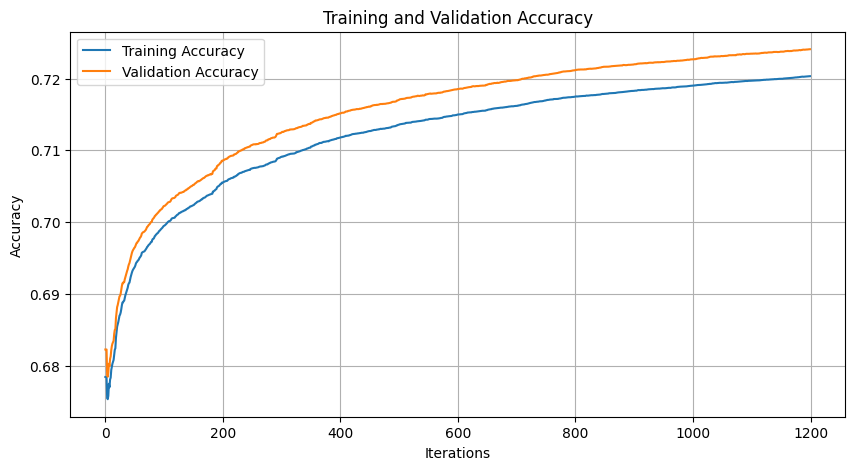

In [21]:
# Retrieve the training and validation results
results = model.get_evals_result()

# Create a plot for the metrics
plt.figure(figsize=(10, 5))
plt.plot(results['learn']['Accuracy'], label='Training Accuracy')
plt.plot(results['validation']['Accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Manual Grid

In [22]:
learning_rates = [0.01, 0.05, 0.1, 0.2]
depths = [3, 4, 6, 8]

# Dictionary to store results
results = {}

In [23]:
# Loop through each combination
for lr in learning_rates:
    for d in depths:
        print(f"Training with learning_rate={lr}, depth={d}")

        # Initialize CatBoost model
        model = CatBoostClassifier(
            iterations=500,
            learning_rate=lr,
            depth=d,
            loss_function='Logloss',
            eval_metric='Accuracy',
            cat_features=cat_cols,
            verbose=False
        )

        # Train the model
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

        # Predict on validation set
        y_pred = model.predict(X_val)

        # Compute accuracy
        acc = accuracy_score(y_val, y_pred)
        print(f"Accuracy: {acc:.4f}\n")

        # Store results
        results[(lr, d)] = acc



Training with learning_rate=0.01, depth=3
Accuracy: 0.6823

Training with learning_rate=0.01, depth=4
Accuracy: 0.7033

Training with learning_rate=0.01, depth=6
Accuracy: 0.7125

Training with learning_rate=0.01, depth=8
Accuracy: 0.7208

Training with learning_rate=0.05, depth=3
Accuracy: 0.7111

Training with learning_rate=0.05, depth=4
Accuracy: 0.7187

Training with learning_rate=0.05, depth=6
Accuracy: 0.7296

Training with learning_rate=0.05, depth=8
Accuracy: 0.7370

Training with learning_rate=0.1, depth=3
Accuracy: 0.7170

Training with learning_rate=0.1, depth=4
Accuracy: 0.7247

Training with learning_rate=0.1, depth=6
Accuracy: 0.7345

Training with learning_rate=0.1, depth=8
Accuracy: 0.7437

Training with learning_rate=0.2, depth=3
Accuracy: 0.7223

Training with learning_rate=0.2, depth=4
Accuracy: 0.7293

Training with learning_rate=0.2, depth=6
Accuracy: 0.7410

Training with learning_rate=0.2, depth=8
Accuracy: 0.7491



In [24]:
# Find the best hyperparameters
best_params = max(results, key=results.get)
best_accuracy = results[best_params]

print(f"Best parameters: learning_rate={best_params[0]}, depth={best_params[1]}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Best parameters: learning_rate=0.2, depth=8
Best validation accuracy: 0.7491


## Best Model

In [25]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.2,
    depth=8,
    loss_function='Logloss',
    eval_metric='Accuracy',
    cat_features=cat_cols,
    verbose=True,
    early_stopping_rounds=60  # Stop if no improvement after 50 iterations
)

# Train model with validation set and plot
model.fit(
    X_train, y_train, 
    eval_set=(X_val, y_val),
    plot=True  # Enable plotting
)

# Print the actual number of iterations the model trained for
print(f"Number of iterations performed: {model.tree_count_}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6860562	test: 0.6895351	best: 0.6895351 (0)	total: 7.8s	remaining: 1h 4m 51s
1:	learn: 0.6890434	test: 0.6923304	best: 0.6923304 (1)	total: 14.8s	remaining: 1h 1m 37s
2:	learn: 0.6909009	test: 0.6941984	best: 0.6941984 (2)	total: 19.7s	remaining: 54m 17s
3:	learn: 0.6926062	test: 0.6960134	best: 0.6960134 (3)	total: 24.6s	remaining: 50m 54s
4:	learn: 0.6956979	test: 0.6994702	best: 0.6994702 (4)	total: 33.1s	remaining: 54m 40s
5:	learn: 0.6995083	test: 0.7035958	best: 0.7035958 (5)	total: 40.7s	remaining: 55m 53s
6:	learn: 0.7017493	test: 0.7059039	best: 0.7059039 (6)	total: 51s	remaining: 59m 52s
7:	learn: 0.7034804	test: 0.7074000	best: 0.7074000 (7)	total: 58.3s	remaining: 59m 43s
8:	learn: 0.7050491	test: 0.7091897	best: 0.7091897 (8)	total: 1m 6s	remaining: 1h 29s
9:	learn: 0.7067352	test: 0.7109669	best: 0.7109669 (9)	total: 1m 16s	remaining: 1h 2m 14s
10:	learn: 0.7076201	test: 0.7118817	best: 0.7118817 (10)	total: 1m 24s	remaining: 1h 2m 34s
11:	learn: 0.7083610	tes

In [27]:
# Predict and calculate metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)
predictions_binary = (predictions >= 0.5).astype(int)  # Ensure binary format if necessary

accuracy = accuracy_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.75
F1 Score: 0.62
Precision: 0.71
Recall: 0.54


In [28]:
import pickle


In [30]:
filename = 'catboost_arrival.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)
print(f"model saved to {filename}")

model saved to catboost_arrival.pkl
